## Target Volatility

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ffn
import bt

%matplotlib inline

### Create Fake Index Data

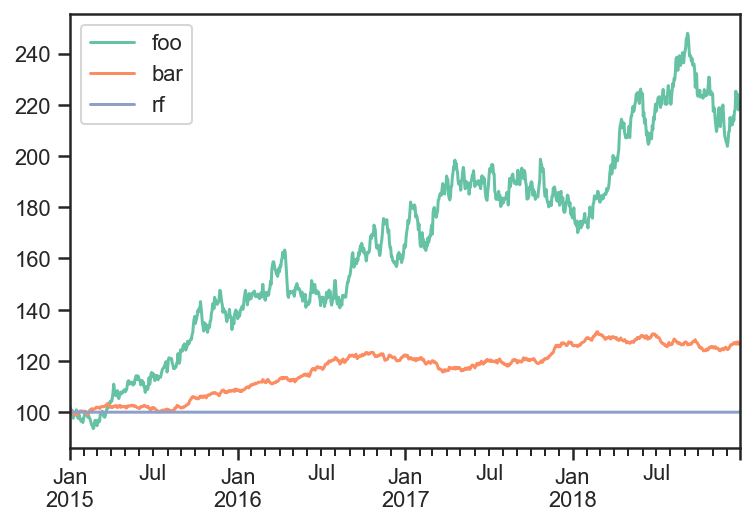

In [2]:
names = ['foo','bar','rf']
dates = pd.date_range(start='2015-01-01',end='2018-12-31', freq=pd.tseries.offsets.BDay())
n = len(dates)
rdf = pd.DataFrame(
    np.zeros((n, len(names))),
    index = dates,
    columns = names
)

np.random.seed(1)
rdf['foo'] = np.random.normal(loc = 0.1/252,scale=0.2/np.sqrt(252),size=n)
rdf['bar'] = np.random.normal(loc = 0.04/252,scale=0.05/np.sqrt(252),size=n)
rdf['rf'] = 0.

pdf = 100*np.cumprod(1+rdf)
pdf.plot();

### Build Strategy

In [3]:
# algo to fire on the beginning of every week and to run on the first date
runWeeklyAlgo = bt.algos.RunWeekly(
    run_on_first_date=True
)

selectTheseAlgo = bt.algos.SelectThese(['foo','bar'])

# algo to set the weights to 1/vol contributions from each asset
#  with data over the last 12 months excluding yesterday
weighInvVolAlgo = bt.algos.WeighInvVol(
    lookback=pd.DateOffset(months=12),
    lag=pd.DateOffset(days=1)
)

# algo to set overall volatility of the portfolio to an annualized 10%
targetVolAlgo = bt.algos.TargetVol(
    0.1,
    lookback=pd.DateOffset(months=12),
    lag=pd.DateOffset(days=1),
    covar_method='standard',
    annualization_factor=252
)


# algo to rebalance the current weights to weights set in target.temp
rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances monthly to specified weights
strat = bt.Strategy('static',
    [
        runWeeklyAlgo,
        selectTheseAlgo,
        weighInvVolAlgo,
        targetVolAlgo,
        rebalAlgo
    ]
)

### Run Backtest

Note: The logic of the strategy is seperate from the data used in the backtest.

In [4]:
# set integer_positions=False when positions are not required to be integers(round numbers)
backtest = bt.Backtest(
    strat,
    pdf,
    integer_positions=False
)

res = bt.run(backtest)

You can see the realized volatility below is close to the targeted 10% volatility.

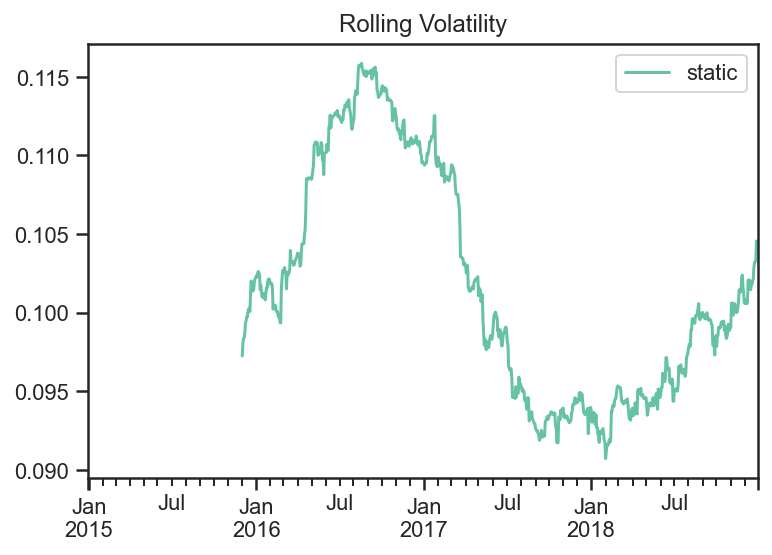

In [5]:
fig, ax = plt.subplots(nrows=1,ncols=1)
(res.prices.pct_change().rolling(window=12*20).std()*np.sqrt(252)).plot(ax = ax)
ax.set_title('Rolling Volatility')
ax.plot();

Because we are using a 1/vol allocation bar, the less risky security, has a much smaller weight.

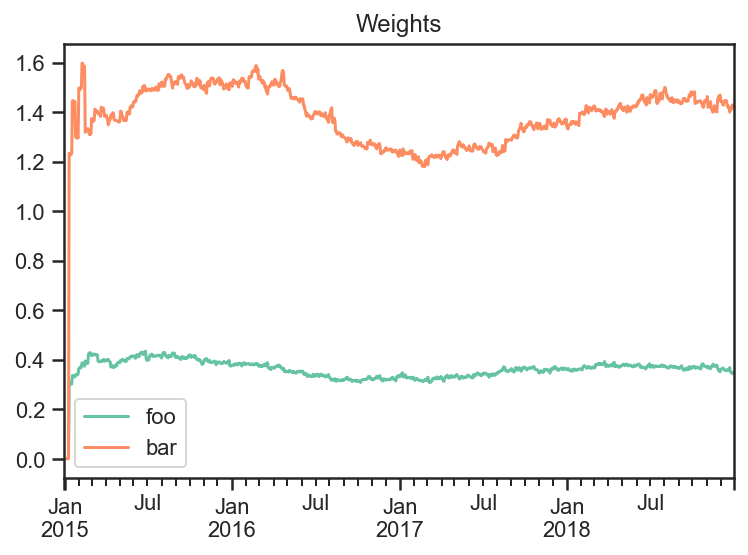

In [6]:
fig, ax = plt.subplots(nrows=1,ncols=1)
res.get_security_weights().plot(ax = ax)
ax.set_title('Weights')
ax.plot();

If we plot the total risk contribution of each asset class and divide by the total volatility, then we can see that both asset's contribute roughly similar amounts of volatility.

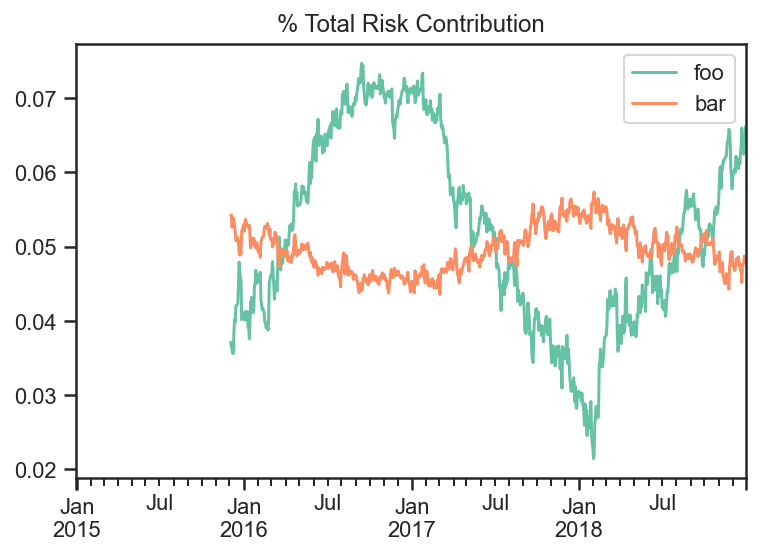

In [7]:
weights = res.get_security_weights()
rolling_cov = pdf.loc[:,weights.columns].pct_change().rolling(window=12*20).cov()*252


trc = pd.DataFrame(
    np.nan,
    index = weights.index,
    columns = weights.columns
)
for dt in pdf.index:
    trc.loc[dt,:] = weights.loc[dt,:].values*rolling_cov.loc[dt,:].values@weights.loc[dt,:].values/np.sqrt(weights.loc[dt,:].values@rolling_cov.loc[dt,:].values@weights.loc[dt,:].values)


fig, ax = plt.subplots(nrows=1,ncols=1)
trc.plot(ax=ax)
ax.set_title('% Total Risk Contribution')
ax.plot();